1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


[-0.00687296 -0.01464092  0.0057658   0.02515226  0.00041908 -0.00605334
 -0.00422599]


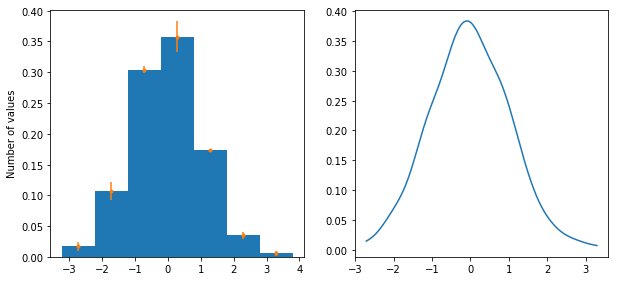

1.1381487187447674 should be close to 0.9999999999999999


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.stats
from scipy.stats import norm

np.random.seed(100)

N = 1000
mu, sigma = 0, 1
x = np.random.normal(mu,sigma, N)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(221)
bins = np.arange(x.min(),x.max())
hist = ax.hist(x, bins=bins, density=True)

ax.set_ylabel("Number of values")

bins = np.arange(x.min()+1/2,x.max()-1/2)
# ax.plot(xpdf, norm.pdf(xpdf), '.')
err = norm.pdf(bins)-hist[0]
print(err)
# ax.plot(xpdf, hist[0])
# ax.plot(xpdf, hist[0]+err)
err = norm.pdf(bins)-hist[0]
ax.errorbar(bins, hist[0], yerr=err, fmt='.')

ax2 = fig.add_subplot(222)
sums = np.array([])

y = np.linspace(bins.min(),bins.max(), N)
scale = 1.06*x.std()*x.size**(-1/5)

for loc in x:
    pdf = norm.pdf(y, loc, scale)
    sums = np.append(sums, pdf)
    
sumpdf = np.sum(sums.reshape(x.size,N),axis=0)/N
ax2.plot(y, sumpdf)

plt.show()

print(scipy.integrate.trapz(sumpdf[1:N:round(N/bins.size)]), 'should be close to', np.sum(hist[0]))

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

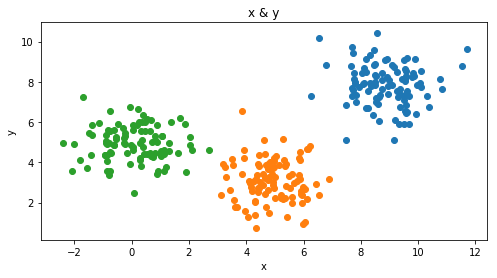

In [6]:
n = 3
N = 100
a = np.arange(N)

fig, ax = plt.subplots(figsize=(8, 4))
mean = np.array([])
cov = mean
for i in range(n):
    mu, sigma = np.random.randint(10), 1 # mean & sigma for category one
    x = np.random.normal(mu,sigma,N) # first category
    mu, sigma = np.random.randint(10), 1 # mean & sigma for category two
    y = np.random.normal(mu,sigma,N) # second category

    ax.scatter(x=x, y=y, marker='o')
    ax.set_title('x & y')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

In [4]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')


'wget' is not recognized as an internal or external command,
operable program or batch file.


TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should you the `np.load()` function to load the file as a numpy array and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

C:\Users\hanah\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'x versus y')

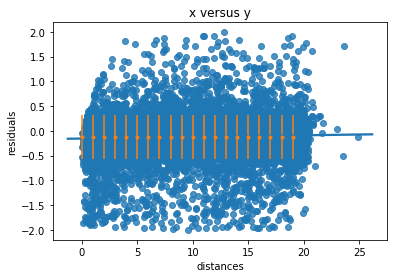

In [21]:
import pandas as pd
import seaborn as sns

data = np.load('residuals_261.npy')
df = pd.DataFrame(data.item())
df = df[np.abs(df['residuals']) < 2]

distances = df['distances']
residuals = df['residuals']
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(distances, residuals)

x = np.arange(0,20)
y = np.array([])
erry = np.array([])
for i in x:
    y = np.append(y, np.mean(residuals))
    erry = np.append(erry, np.std(residuals))

f, ax = plt.subplots()
sns.regplot(distances, residuals, ax=ax)
ax.errorbar(x, y, yerr=erry, fmt='.')
ax.set_title('x versus y')
